In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control

# 「- Damped Walker -」

In [2]:
def compute_A_ss(params_args, theta1_i, omega1_i, theta2_i, omega2_i):
    M, m, I, l, c, g, d, gam = params_args
    A11 = (
        2 * I
        + M * l ** 2
        + 2 * c ** 2 * m
        + 2 * l ** 2 * m
        - 2 * c * l * m
        - 2 * c * l * m * np.cos(theta2_i)
    )
    A12 = I + c ** 2 * m - c * l * m * np.cos(theta2_i)
    A21 = A12
    A22 = I + c ** 2 * m
    return np.array([[A11, A12], [A21, A22]])

def compute_b_ss(params_args, theta1_i, omega1_i, theta2_i, omega2_i):
    M, m, I, l, c, g, d, gam = params_args
    b1 = (
        c * g * m * np.sin(gam - theta1_i)
        - M * g * l * np.sin(gam - theta1_i)
        - c * g * m * np.sin(theta1_i - gam + theta2_i)
        - 2 * g * l * m * np.sin(gam - theta1_i)
        - c * l * m * omega2_i ** 2 * np.sin(theta2_i)
        - 2 * c * l * m * omega1_i * omega2_i * np.sin(theta2_i)
    )
    b2 = -c * m * (
        g * np.sin(theta1_i - gam + theta2_i)
        - l * omega1_i ** 2 * np.sin(theta2_i)
    )
    return np.array([b1, b2]) 

def compute_J(params_args, theta1_n, omega1_n, theta2_n, omega2_n):
    M, m, I, l, c, g, d, gam = params_args
    J11 = 1
    J12 = 0
    J13 = l * (np.cos(theta1_n + theta2_n) - np.cos(theta1_n))
    J14 = l * np.cos(theta1_n + theta2_n)
    J21 = 0
    J22 = 1
    J23 = l * (np.sin(theta1_n + theta2_n) - np.sin(theta1_n))
    J24 = l * np.sin(theta1_n + theta2_n)
    return np.array([[J11, J12, J13, J14], [J21, J22, J23, J24]])

def compute_A_n_hs(params_args, theta1_n, omega1_n, theta2_n, omega2_n):
    M, m, I, l, c, g, d, gam = params_args
    A11 = M + 2 * m
    A12 = 0
    A13 = (
        m * (2 * c * np.cos(theta1_n + theta2_n) - 2 * l * np.cos(theta1_n)) / 2
        + m * np.cos(theta1_n) * (c - l)
        - M * l * np.cos(theta1_n)
    )
    A14 = c * m * np.cos(theta1_n + theta2_n)
    A21 = 0
    A22 = M + 2 * m
    A23 = (
        m * (2 * c * np.sin(theta1_n + theta2_n) - 2 * l * np.sin(theta1_n)) / 2
        - M * l * np.sin(theta1_n)
        + m * np.sin(theta1_n) * (c - l)
    )
    A24 = c * m * np.sin(theta1_n + theta2_n)
    A31 = A13
    A32 = A23
    A33 = (
        2 * I
        + M * l ** 2
        + 2 * c ** 2 * m
        + 2 * l ** 2 * m
        - 2 * c * l * m
        - 2 * c * l * m * np.cos(theta2_n)
    )
    A34 = I + c ** 2 * m - c * l * m * np.cos(theta2_n)
    A41 = c * m * np.cos(theta1_n + theta2_n)
    A42 = c * m * np.sin(theta1_n + theta2_n)
    A43 = A34
    A44 = I + c ** 2 * m
    return np.array(
                        [
                            [A11, A12, A13, A14],
                            [A21, A22, A23, A24],
                            [A31, A32, A33, A34],
                            [A41, A42, A43, A44],
                        ]
                    )

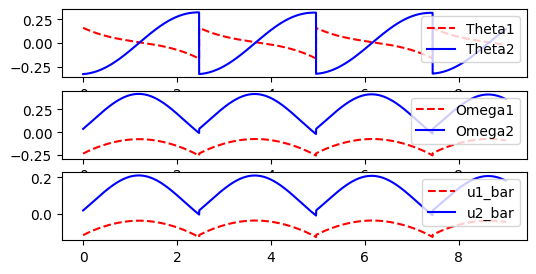

In [3]:
# Parameters
M = 1.0
m = 0.5
I = 0.02
l = 1.0
c = 0.5
g = 1.0
d = 0.5
gam = 0.01
params_args = (M, m, I, l, c, g, d, gam)

# Initial conditions
theta1_0 = 0.162597833780041
omega1_0 = -0.231869638058930
theta2_0 = -0.325195667560083
omega2_0 = 0.037978468073743

# Time parameters
dt = 1e-3
T = 9
N = int(T/dt)
time = np.linspace(0, T, N)

# Initialize arrays
theta1 = np.zeros(N)
omega1 = np.zeros(N)
theta2 = np.zeros(N)
omega2 = np.zeros(N)
u1 = np.zeros(N)
u2 = np.zeros(N)

# Set initial conditions
theta1[0] = theta1_0
omega1[0] = omega1_0
theta2[0] = theta2_0
omega2[0] = omega2_0
u1[0] = d * omega1_0
u2[0] = d * omega2_0

# Simulation loop
for i in range(1, N):
    
    ''' ================================ Continuous Dynamics ==================================== '''
    # Previous values
    theta1_i = theta1[i - 1]
    omega1_i = omega1[i - 1]
    theta2_i = theta2[i - 1]
    omega2_i = omega2[i - 1]

    # Compute A_ss
    A_ss = compute_A_ss(params_args, theta1_i, omega1_i, theta2_i, omega2_i)

    # Compute b_ss
    b_ss = compute_b_ss(params_args, theta1_i, omega1_i, theta2_i, omega2_i)

    # Nominal controller
    u1_bar = d * omega1_i
    u2_bar = d * omega2_i

    # Solve for alpha1, alpha2
    alphas = np.linalg.solve(A_ss, b_ss)
    alpha1 = alphas[0] - d * omega1_i + u1_bar
    alpha2 = alphas[1] - d * omega2_i + u2_bar

    # Update omega1 and omega2
    omega1_i_new = omega1_i + alpha1 * dt
    omega2_i_new = omega2_i + alpha2 * dt

    # Update theta1 and theta2
    theta1_i_new = theta1_i + omega1_i_new * dt
    theta2_i_new = theta2_i + omega2_i_new * dt

    ''' ================================ Switch Dynamics ==================================== '''
    if (i>10) and abs(theta2_i>0.1) and abs(theta2_i + 2 * theta1_i) < 0.001:

        # Store previous values
        theta1_n = theta1_i
        omega1_n = omega1_i
        theta2_n = theta2_i
        omega2_n = omega2_i

        # Update theta1 and theta2
        theta1_i_new = theta1_n + theta2_n
        theta2_i_new = -theta2_n

        # Compute J
        J = compute_J(params_args, theta1_n, omega1_n, theta2_n, omega2_n)

        # Compute A_n_hs
        A_n_hs = compute_A_n_hs(params_args, theta1_n, omega1_n, theta2_n, omega2_n)

        # Compute b_hs
        X_n_hs = np.array([0, 0, omega1_n, omega2_n])
        b_hs = A_n_hs @ X_n_hs

        # Compute A_hs
        A_hs = np.block([[A_n_hs, -J.T], [J, np.zeros((2, 2))]])

        # RHS vector
        rhs = np.concatenate([b_hs, [0, 0]])

        # Solve for X_hs
        X_hs = np.linalg.solve(A_hs, rhs)

        # Update omega1 and omega2
        omega1_i_new = X_hs[2] + X_hs[3]
        omega2_i_new = -X_hs[3]

    # Store new values
    theta1[i] = theta1_i_new
    omega1[i] = omega1_i_new
    theta2[i] = theta2_i_new
    omega2[i] = omega2_i_new
    u1[i] = u1_bar
    u2[i] = u2_bar

# Plotting the results
plt.figure(figsize=(6, 3))

# Subplot 1: Theta1 and Theta2
plt.subplot(3, 1, 1)
plt.plot(time, theta1, label='Theta1', color='red', linestyle='dashed')
plt.plot(time, theta2, label='Theta2', color='blue')
plt.legend()

# Subplot 2: Omega1 and Omega2
plt.subplot(3, 1, 2)
plt.plot(time, omega1, label='Omega1', color='red', linestyle='dashed')
plt.plot(time, omega2, label='Omega2', color='blue')
plt.legend()

# Subplot 2: u1, u2 nominal control profile
plt.subplot(3, 1, 3)
plt.plot(time, u1, label='u1_bar', color='red', linestyle='dashed')
plt.plot(time, u2, label='u2_bar', color='blue')
plt.legend()
plt.show()

# Store reference values for later use
time_ref = time
theta1_ref = theta1
theta2_ref = theta2
omega1_ref = omega1
omega2_ref = omega2
u1_ref = u1
u2_ref = u2


# 「- Hankel Prediction -」

Pre-process data set dimension (900, 6)
Time snap shot (M): 900
Original state dimension (n): 6
Hankel delay (ts): 300
Hankel window (tw): 600
Hankel matrix dimension (1800, 600)
L.shape (1800, 1800)


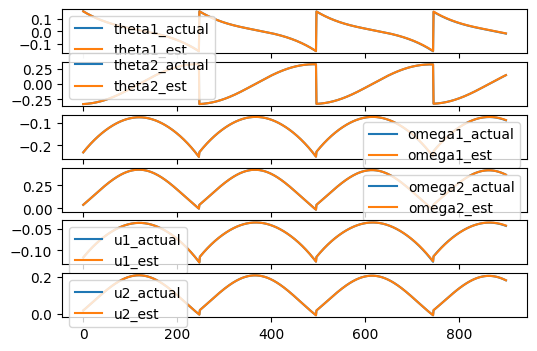

In [4]:
sample_rate = 10
time_sample = time[::sample_rate]
theta1_sample = theta1[::sample_rate]
theta2_sample = theta2[::sample_rate]
omega1_sample = omega1[::sample_rate]
omega2_sample = omega2[::sample_rate]
u1_sample = u1[::sample_rate]
u2_sample = u2[::sample_rate]
data_set = np.column_stack((theta1_sample, theta2_sample, omega1_sample, omega2_sample, u1_sample, u2_sample))
print('Pre-process data set dimension', data_set.shape)
print(f"Time snap shot (M): {data_set.shape[0]}")
print(f'Original state dimension (n): {data_set.shape[1]}')
print('=============')

H = []
n = 6    # original state space dimension
ts = 300 # the row size of H
tw = 600 # the col size of H, and make sure (ts + tw) < n_steps

for i in range(ts):  
    H.append(data_set[i:tw+i,:].T)       # Extract and transpose
H = np.vstack(H)                         # Stack all elements vertically
print('Hankel delay (ts):', ts )         # = original_state_dim * delay_state
print('Hankel window (tw):', tw)
print('Hankel matrix dimension', H.shape)
print('=============')

edmd_snap_X = H[:, :-1]
edmd_snap_Y = H[:, 1:]
L = np.dot(edmd_snap_Y, np.linalg.pinv(edmd_snap_X))
print('L.shape', L.shape)

x0 = H[:,0]
x_edmd = np.zeros((data_set.shape[0], x0.size))
x_edmd[0] = x0.copy()
for i in range(data_set.shape[0]-1):
    x_edmd[i + 1] =(L @ x_edmd[i])

figure = plt.figure(figsize=(6,4))
plt.subplot(6,1,1)
plt.plot(data_set[:,0], label='theta1_actual')
plt.plot(x_edmd[:,0], label='theta1_est')
plt.legend()
plt.subplot(6,1,2)
plt.plot(data_set[:,1], label='theta2_actual')
plt.plot(x_edmd[:,1], label='theta2_est')
plt.legend()
plt.subplot(6,1,3)
plt.plot(data_set[:,2], label='omega1_actual')
plt.plot(x_edmd[:,2], label='omega1_est')
plt.legend()
plt.subplot(6,1,4)
plt.plot(data_set[:,3], label='omega2_actual')
plt.plot(x_edmd[:,3], label='omega2_est')
plt.legend()
plt.subplot(6,1,5)
plt.plot(data_set[:,4], label='u1_actual')
plt.plot(x_edmd[:,4], label='u1_est')
plt.legend()
plt.subplot(6,1,6)
plt.plot(data_set[:,5], label='u2_actual')
plt.plot(x_edmd[:,5], label='u2_est')
plt.legend()
plt.show()    

# 「- LQR Gain K Design -」

In [5]:
def euler_discrete_to_continuous(A, B, dt):
    A_c = (A - np.eye(A.shape[0])) / dt
    B_c = B / dt
    return A_c, B_c

L_bar_top_blocks = []
L_bar_bottom_blocks = []

for i in range(ts):
    start = i * 6
    L_bar_top_blocks.append(L[start:start+4, :])  # (4, n)
    L_bar_bottom_blocks.append(L[start+4:start+6, :])  # (2, n)

L_bar_top = np.vstack(L_bar_top_blocks)  
L_bar_bottom = np.vstack(L_bar_bottom_blocks)  
print('L_x.shape', L_bar_top.shape)
print('L_u.shape', L_bar_bottom.shape)

A = L_bar_top[:, :4*ts]
B = L_bar_top[:, 4*ts:]
print('A.shape', A.shape)
print('B.shape', B.shape)

A_c, B_c = euler_discrete_to_continuous(A, B, sample_rate * dt)
print('A_c.shape', A_c.shape)
print('B_c.shape', B_c.shape)


L_x.shape (1200, 1800)
L_u.shape (600, 1800)
A.shape (1200, 1200)
B.shape (1200, 600)
A_c.shape (1200, 1200)
B_c.shape (1200, 600)


In [7]:
q_theta1 = 1e-9
q_theta2 = 1e-9
q_omega1 = 1e-9
q_omega2 = 1e-9
q = [val for _ in range(ts) for val in [q_theta1, q_theta2, q_omega1, q_omega2]]
q[-4] = 1e8
q[-3] = 1e8
q[-2] = 1e8
q[-1] = 1e8
Q = np.diag(q)
r = [1e3] * ts * 2 
R = np.diag(r)
print('Q.shape', Q.shape)
print('R.shape', R.shape)

# K, S, E = control.lqr(A_c, B_c, Q, R)
K = np.load('_mecc_walker_K.npy')
print('K.shape', K.shape)
print('NOTE: It takes 3 minutes for my computation to calculate \nthe K matrix. Uncomment the LQR line if you want to test \nthe new gain setup yourself, or you can simply use the matrix \nI have pre-calculated for you.')

Q.shape (1200, 1200)
R.shape (600, 600)
K.shape (600, 1200)
NOTE: It takes 3 minutes for my computation to calculate 
the K matrix. Uncomment the LQR line if you want to test 
the new gain setup yourself, or you can simply use the matrix 
I have pre-calculated for you.


# 「- Control Result -」

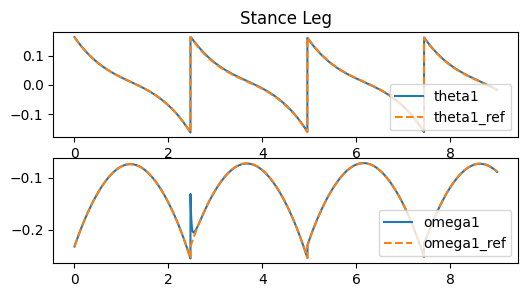

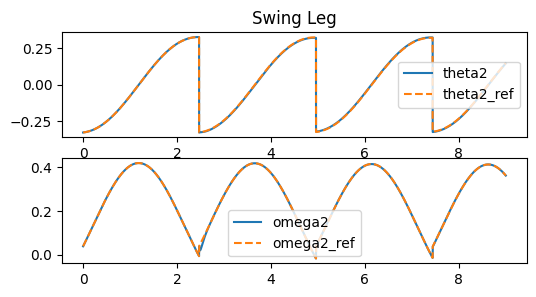

In [9]:
# Storage for simulation results
theta1 = np.zeros(N)
omega1 = np.zeros(N)
theta2 = np.zeros(N)
omega2 = np.zeros(N)
u1 = np.zeros(N)
u2 = np.zeros(N)
theta1[0] = theta1_0
omega1[0] = omega1_0
theta2[0] = theta2_0
omega2[0] = omega2_0
u1[0] = d * omega1_0
u2[0] = d * omega2_0
theta1_data = [theta1_0]
theta2_data = [theta2_0]
omega1_data = [omega1_0]
omega2_data = [omega2_0]
u1_data = [d * omega1_0]
u2_data = [d * omega2_0]
time_data = [0]

# Impulse Disturbance
step_counter = 0
impulse_step = 1
impulse_magnitude = 0.1
impulse_applied = True

# Controllers
lqr_applied = True
u1_hat, u2_hat = 0, 0

c_t = 0
for i in range(1, N):

    ''' ================================ Continuous Dynamics ==================================== '''
    # Previous state values
    theta1_i = theta1[i - 1]
    omega1_i = omega1[i - 1]
    theta2_i = theta2[i - 1]
    omega2_i = omega2[i - 1]
    u1_bar = d * omega1_i
    u2_bar = d * omega2_i

    # Compute A_ss
    A_ss = compute_A_ss(params_args, theta1_i, omega1_i, theta2_i, omega2_i)

    # Compute b_ss
    b_ss = compute_b_ss(params_args, theta1_i, omega1_i, theta2_i, omega2_i)

    # Nominal controller
    u1_bar = d * omega1_i
    u2_bar = d * omega2_i

    # Solve for accelerations alpha1 and alpha2
    alphas = np.linalg.solve(A_ss, b_ss)
    alpha1 = alphas[0] - d * omega1_i + u1_bar + u1_hat
    alpha2 = alphas[1] - d * omega2_i + u2_bar + u2_hat

    # Update omega1 and omega2
    omega1_i_new = omega1_i + alpha1 * dt
    omega2_i_new = omega2_i + alpha2 * dt

    # Update theta1 and theta2
    theta1_i_new = theta1_i + omega1_i_new * dt
    theta2_i_new = theta2_i + omega2_i_new * dt
    
    ''' ================================ Switch Dynamics ==================================== '''
    if (i > 10) and abs(theta2_i > 0.1) and abs(theta2_i + 2 * theta1_i) < 0.001:

        # Increase the step counter (switching event)
        step_counter += 1

        # Store previous values
        theta1_n = theta1_i
        omega1_n = omega1_i
        theta2_n = theta2_i
        omega2_n = omega2_i

        # Update theta1 and theta2
        theta1_i_new = theta1_n + theta2_n
        theta2_i_new = -theta2_n


        # Compute J
        J = compute_J(params_args, theta1_n, omega1_n, theta2_n, omega2_n)

        # Compute A_n_hs
        A_n_hs = compute_A_n_hs(params_args, theta1_n, omega1_n, theta2_n, omega2_n)

        # Compute b_hs
        X_n_hs = np.array([0, 0, omega1_n, omega2_n])
        b_hs = A_n_hs @ X_n_hs

        # Compute A_hs
        A_hs = np.block([[A_n_hs, -J.T], [J, np.zeros((2, 2))]])

        # RHS vector
        rhs = np.concatenate([b_hs, [0, 0]])

        # Solve for X_hs
        X_hs = np.linalg.solve(A_hs, rhs)

        # Update omega1 and omega2
        omega1_i_new = X_hs[2] + X_hs[3]
        omega2_i_new = -X_hs[3]

        # Apply a small impulse after the second step if required
        if step_counter == impulse_step and impulse_applied:
            omega1_i_new += impulse_magnitude

    ''' ================================ LQR Controller ==================================== '''
    if len(theta1_data) < ts: # --- Collect Hankel history state

        # Create padding arrays filled with the initial condition values
        pad_rows = ts - len(theta1_data)
        pad_theta1 = np.full(pad_rows, theta1_data[0])
        pad_theta2 = np.full(pad_rows, theta2_data[0])
        pad_omega1 = np.full(pad_rows, omega1_data[0])
        pad_omega2 = np.full(pad_rows, omega2_data[0])
        
        # Concatenate the padding with the available data
        padded_theta1 = np.concatenate((pad_theta1, theta1_data))
        padded_theta2 = np.concatenate((pad_theta2, theta2_data))
        padded_omega1 = np.concatenate((pad_omega1, omega1_data))
        padded_omega2 = np.concatenate((pad_omega2, omega2_data))
        padded_X = np.column_stack((padded_theta1, padded_theta2, padded_omega1, padded_omega2))
    else:
        padded_X = np.column_stack((theta1_data[-ts:], theta2_data[-ts:], omega1_data[-ts:], omega2_data[-ts:]))
    X_history = padded_X[1:, :].reshape(-1)
    X_current = np.array([theta1_i_new, theta2_i_new, omega1_i_new, omega2_i_new])
    X = np.concatenate([X_history, X_current])
    
    if len(theta1_data) < ts: # --- Collect Hankel reference
        
        # Create padding arrays filled with the initial condition values
        pad_rows = ts - len(theta1_data)
        pad_theta1_ref = np.full(pad_rows, theta1_ref[0])
        pad_theta2_ref = np.full(pad_rows, theta2_ref[0])
        pad_omega1_ref = np.full(pad_rows, omega1_ref[0])
        pad_omega2_ref = np.full(pad_rows, omega2_ref[0])

        # Concatenate the padding with the available data
        padded_theta1_ref = np.concatenate((pad_theta1_ref, theta1_ref[:len(theta1_data)]))
        padded_theta2_ref = np.concatenate((pad_theta2_ref, theta2_ref[:len(theta1_data)]))
        padded_omega1_ref = np.concatenate((pad_omega1_ref, omega1_ref[:len(theta1_data)]))
        padded_omega2_ref = np.concatenate((pad_omega2_ref, omega2_ref[:len(theta1_data)]))
        paddded_Xref = np.column_stack((padded_theta1_ref, padded_theta2_ref, padded_omega1_ref, padded_omega2_ref))
    else:
        paddded_Xref = np.column_stack((theta1_ref[i-ts:i], theta2_ref[i-ts:i], omega1_ref[i-ts:i], omega2_ref[i-ts:i]))
    Xref_history = paddded_Xref[1:, :].reshape(-1)
    Xref_current = np.array([theta1_ref[i], theta2_ref[i], omega1_ref[i], omega2_ref[i]])
    Xref = np.concatenate([Xref_history, Xref_current])

    Error = (Xref - X).reshape(-1,1)
    u_lqr = K @ Error
    u_lqr = u_lqr.reshape(-1)
    u_lqr = u_lqr[-2:]
    if lqr_applied:
        u1_hat = u_lqr[0]
        u2_hat = u_lqr[1]
        # print(f'lqr_tau1: {u_lqr[0]:.3f} and lqr_tau2: {u_lqr[1]:.3f}')

    # Store the updated states
    theta1[i] = theta1_i_new
    omega1[i] = omega1_i_new
    theta2[i] = theta2_i_new
    omega2[i] = omega2_i_new
    u1[i] = u1_bar
    u2[i] = u2_bar
    c_t = i * dt
    theta1_data.append(theta1_i_new)
    theta2_data.append(theta2_i_new)
    omega1_data.append(omega1_i_new)
    omega2_data.append(omega2_i_new)
    u1_data.append(u1_bar)
    u2_data.append(u2_bar)
    time_data.append(c_t)

figure = plt.figure(figsize=(6,3))
plt.subplot(2, 1, 1)
plt.plot(time_data, theta1_data, label='theta1')
plt.plot(time_ref[:len(time_data)], theta1_ref[:len(time_data)], label='theta1_ref', linestyle='dashed')
plt.title('Stance Leg')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time_data, omega1_data, label='omega1')
plt.plot(time_ref[:len(time_data)], omega1_ref[:len(time_data)], label='omega1_ref', linestyle='dashed')
plt.legend()
plt.show()
figure = plt.figure(figsize=(6,3))
plt.subplot(2, 1, 1)
plt.plot(time_data, theta2_data, label='theta2')
plt.plot(time_ref[:len(time_data)], theta2_ref[:len(time_data)], label='theta2_ref', linestyle='dashed')
plt.title('Swing Leg')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time_data, omega2_data, label='omega2')
plt.plot(time_ref[:len(time_data)], omega2_ref[:len(time_data)], label='omega2_ref', linestyle='dashed')
plt.legend()
plt.show()